<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Point Source Flux Conservation Modeshep

<span style="color:red"> **Instruments Affected**</span>: MIRI

Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br>[Run JWST Pipeline](#pipeline_ID) <br> [Examine Input and Output Data](#examine_data)  <br> [About This Notebook](#about_ID) <br>


</div>

## Author: Isha Nayak
## Last Modified: September 15
## The purpose of this notebook is to check if you input either a flat point source or flat extended source, then the output is also flat. We check the flatness of a source by inputting a known flat source, then checking the output three different ways: (1) our own code which sums up the total flux, (2) the cube build algorithm, and (3) extract 1D algorithm. We want to make sure nothing strange is happening during the cube build and extract 1D steps.

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)
print(data_dir)

<TemporaryDirectory '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpfeq5xpd6'>


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


In [3]:
# Check jwst pipeline version
import jwst
jwst.__version__

'1.3.2'

In [4]:
#Import inject psf
import miri3d.tools.inject_psf as ip

#Import assign wcs
from jwst.assign_wcs import AssignWcsStep

#Import modshep
import miri3d.modshep.modshep as modshep

#Import plotting things
import matplotlib.pyplot as plt

#Import fits file things
from astropy.io import fits

#Import cube build
from jwst.cube_build import CubeBuildStep

#Import extract1D
from jwst.extract_1d import Extract1dStep

#Import table
from astropy.table import Table

import sys
from ci_watson.artifactory_helpers import get_bigdata

#### Run the inject_psf code for point source with the following:
#### ip.main('12A',[1,2],1,1e-7)
#### This would give a standard 2-pt dither in Ch12A with a specified PSF total (total=1) and background/extended value (1e-7).
#### Run the inject_psf code for extended source with the following:
#### inject_psf.main('12A',[1,2,3,4],0,1)
#### This would give a standard 2-pt dither in Ch12A with no specified PSF and an extended source with flat spectrum of 1.
#### The output should be two scene files, two mock files, and two mockarea files.

In [5]:
# Read association file in from artifactory

asnfile = get_bigdata('jwst_validation_notebooks',
                      'validation_data',
                      'cube_build',
                      'cube_build_miri_test',
                      'cube_testing.json')

In [6]:
#Define band and channels
band_chan=['12A','34A','12B','34B','12C','34C']

#Define Channels 1 and 3
indiv1=['1A','3A','1B','3B','1C','3C']

#Define Channels 2 and 4
indiv2=['2A','4A','2B','4B','2C','4C']

#Define plot colors for each band
plot_color=['black','black','blue','blue','red','red']

#### Using D. Law's injest_psf code to first define a flat point source or flat extended source in a particular band/channel which does not depend on JWST pipeline for distortion transforms. Then this uses D. Law's modshep code as a standalone implementation of modified Sheperd's cube building algorithm. We need to correct units and plot the output from the modshep algorithm.



Setting up the dithers
Ndither =  2


Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2022-01-28 22:24:14,769 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-28 22:24:14,898 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12A-00.fits',).


2022-01-28 22:24:14,899 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-28 22:24:18,616 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-28 22:24:20,867 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999701301 -0.000573586 45.000903166 -0.000573586 45.000903166 0.000677844 44.999701301 0.000677844


2022-01-28 22:24:20,870 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-28 22:24:21,959 - stpipe.AssignWcsStep - INFO - Saved model in mock12A-00_assignwcsstep.fits


2022-01-28 22:24:21,960 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-01-28 22:24:23,061 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-28 22:24:23,258 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12A-01.fits',).


2022-01-28 22:24:23,261 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-28 22:24:26,997 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-28 22:24:29,326 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999150321 -0.000846948 45.000352187 -0.000846948 45.000352187 0.000404482 44.999150321 0.000404482


2022-01-28 22:24:29,327 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-28 22:24:30,183 - stpipe.AssignWcsStep - INFO - Saved model in mock12A-01_assignwcsstep.fits


2022-01-28 22:24:30,184 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 4.89 - 5.74 micron
RA limits: 44.9992 - 45.0008 deg
DEC limits: -0.0006 - 0.0006 deg
XI limits: -2.925 - 2.925 deg
ETA limits: -2.405 - 2.405 deg
Cube X-Y-Z dimensions: [44, 36, 851] spaxels
Radius of influence in X-Y-Z direction: [3.076923076923077, 3.076923076923077, 2.5] pixels
Exponential weighting sigma: 0.7692307692307693 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  80 % complete


Constructing cube:  85 % complete


Constructing cube:  90 % complete


Constructing cube:  96 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 7.49 - 8.75 micron
RA limits: 44.9992 - 45.0009 deg
DEC limits: -0.0008 - 0.0007 deg
XI limits: -3.315 - 3.315 deg
ETA limits: -2.975 - 2.975 deg
Cube X-Y-Z dimensions: [38, 34, 630] spaxels
Radius of influence in X-Y-Z direction: [3.529411764705882, 3.529411764705882, 2.5] pixels
Exponential weighting sigma: 0.8823529411764705 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  66 % complete


Constructing cube:  71 % complete


Constructing cube:  76 % complete


Constructing cube:  81 % complete


Constructing cube:  86 % complete


Constructing cube:  91 % complete


Constructing cube:  96 % complete


Setting up the dithers
Ndither =  2
Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection
Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2022-01-28 23:14:34,129 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-28 23:14:34,331 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34A-00.fits',).


2022-01-28 23:14:34,333 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-28 23:14:37,229 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-28 23:14:39,172 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999232122 -0.001058168 45.001454621 -0.001058168 45.001454621 0.000986969 44.999232122 0.000986969


2022-01-28 23:14:39,174 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-28 23:14:39,855 - stpipe.AssignWcsStep - INFO - Saved model in mock34A-00_assignwcsstep.fits


2022-01-28 23:14:39,856 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-01-28 23:14:41,075 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-28 23:14:41,252 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34A-01.fits',).


2022-01-28 23:14:41,254 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-28 23:14:44,040 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-28 23:14:45,928 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.998681142 -0.001331530 45.000903642 -0.001331530 45.000903642 0.000713608 44.998681142 0.000713608


2022-01-28 23:14:45,930 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-28 23:14:46,603 - stpipe.AssignWcsStep - INFO - Saved model in mock34A-01_assignwcsstep.fits


2022-01-28 23:14:46,605 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 11.53 - 13.48 micron
RA limits: 44.9987 - 45.001 deg
DEC limits: -0.001 - 0.0009 deg
XI limits: -4.5 - 4.5 deg
ETA limits: -3.7 - 3.7 deg
Cube X-Y-Z dimensions: [44, 36, 651] spaxels
Radius of influence in X-Y-Z direction: [4.5, 4.5, 2.3333333333333335] pixels
Exponential weighting sigma: 1.0 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  76 % complete


Constructing cube:  81 % complete


Constructing cube:  86 % complete


Constructing cube:  91 % complete


Constructing cube:  96 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 17.66 - 20.93 micron
RA limits: 44.9987 - 45.0015 deg
DEC limits: -0.0013 - 0.001 deg
XI limits: -5.425 - 5.425 deg
ETA limits: -4.375 - 4.375 deg
Cube X-Y-Z dimensions: [30, 24, 545] spaxels
Radius of influence in X-Y-Z direction: [5.142857142857143, 5.142857142857143, 2.0] pixels
Exponential weighting sigma: 0.8571428571428572 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  4 % complete


Constructing cube:  9 % complete


Constructing cube:  14 % complete


Constructing cube:  19 % complete


Constructing cube:  24 % complete


Constructing cube:  29 % complete


Constructing cube:  34 % complete


Constructing cube:  39 % complete


Constructing cube:  44 % complete


Constructing cube:  49 % complete


Constructing cube:  54 % complete


Constructing cube:  59 % complete


Constructing cube:  64 % complete


Constructing cube:  69 % complete


Constructing cube:  74 % complete


Constructing cube:  79 % complete


Constructing cube:  84 % complete


Constructing cube:  89 % complete


Constructing cube:  94 % complete


Constructing cube:  99 % complete


Setting up the dithers
Ndither =  2
Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2022-01-29 00:05:06,206 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-29 00:05:06,380 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12B-00.fits',).


2022-01-29 00:05:06,382 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-29 00:05:09,940 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-29 00:05:12,097 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999671539 -0.000648325 45.000874839 -0.000648325 45.000874839 0.000604299 44.999671539 0.000604299


2022-01-29 00:05:12,099 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-29 00:05:13,181 - stpipe.AssignWcsStep - INFO - Saved model in mock12B-00_assignwcsstep.fits


2022-01-29 00:05:13,183 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-01-29 00:05:14,096 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-29 00:05:14,373 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12B-01.fits',).


2022-01-29 00:05:14,376 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-29 00:05:18,017 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-29 00:05:20,194 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999120559 -0.000921687 45.000323860 -0.000921687 45.000323860 0.000330937 44.999120559 0.000330937


2022-01-29 00:05:20,196 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-29 00:05:20,990 - stpipe.AssignWcsStep - INFO - Saved model in mock12B-01_assignwcsstep.fits


2022-01-29 00:05:20,991 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 5.64 - 6.62 micron
RA limits: 44.9993 - 45.0008 deg
DEC limits: -0.0007 - 0.0006 deg
XI limits: -2.925 - 2.925 deg
ETA limits: -2.405 - 2.405 deg
Cube X-Y-Z dimensions: [44, 36, 981] spaxels
Radius of influence in X-Y-Z direction: [1.5384615384615385, 1.5384615384615385, 2.5] pixels
Exponential weighting sigma: 0.7692307692307693 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  4 % complete


Constructing cube:  9 % complete


Constructing cube:  14 % complete


Constructing cube:  19 % complete


Constructing cube:  24 % complete


Constructing cube:  29 % complete


Constructing cube:  34 % complete


Constructing cube:  39 % complete


Constructing cube:  44 % complete


Constructing cube:  49 % complete


Constructing cube:  54 % complete


Constructing cube:  59 % complete


Constructing cube:  64 % complete


Constructing cube:  69 % complete


Constructing cube:  74 % complete


Constructing cube:  79 % complete


Constructing cube:  84 % complete


Constructing cube:  89 % complete


Constructing cube:  94 % complete


Constructing cube:  99 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 8.72 - 10.22 micron
RA limits: 44.9991 - 45.0009 deg
DEC limits: -0.0009 - 0.0006 deg
XI limits: -3.315 - 3.315 deg
ETA limits: -2.975 - 2.975 deg
Cube X-Y-Z dimensions: [38, 34, 750] spaxels
Radius of influence in X-Y-Z direction: [3.529411764705882, 3.529411764705882, 2.5] pixels
Exponential weighting sigma: 0.8823529411764705 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  76 % complete


Constructing cube:  81 % complete


Constructing cube:  86 % complete


Constructing cube:  91 % complete


Constructing cube:  96 % complete


Setting up the dithers
Ndither =  2
Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene
Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2022-01-29 00:54:39,694 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-29 00:54:39,878 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34B-00.fits',).


2022-01-29 00:54:39,880 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-29 00:54:42,619 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-29 00:54:44,439 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999292174 -0.001045109 45.001442012 -0.001045109 45.001442012 0.001002862 44.999292174 0.001002862


2022-01-29 00:54:44,442 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-29 00:54:45,079 - stpipe.AssignWcsStep - INFO - Saved model in mock34B-00_assignwcsstep.fits


2022-01-29 00:54:45,080 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-01-29 00:54:46,157 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-29 00:54:46,328 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34B-01.fits',).


2022-01-29 00:54:46,330 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-29 00:54:49,005 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-29 00:54:51,214 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.998741194 -0.001318471 45.000891032 -0.001318471 45.000891032 0.000729501 44.998741194 0.000729501


2022-01-29 00:54:51,216 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-29 00:54:51,856 - stpipe.AssignWcsStep - INFO - Saved model in mock34B-01_assignwcsstep.fits


2022-01-29 00:54:51,857 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 13.37 - 15.64 micron
RA limits: 44.9988 - 45.0011 deg
DEC limits: -0.001 - 0.0009 deg
XI limits: -4.3 - 4.3 deg
ETA limits: -3.7 - 3.7 deg
Cube X-Y-Z dimensions: [42, 36, 757] spaxels
Radius of influence in X-Y-Z direction: [4.5, 4.5, 2.3333333333333335] pixels
Exponential weighting sigma: 1.0 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  80 % complete


Constructing cube:  85 % complete


Constructing cube:  90 % complete


Constructing cube:  95 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 20.42 - 24.21 micron
RA limits: 44.9987 - 45.0014 deg
DEC limits: -0.0013 - 0.001 deg
XI limits: -5.075 - 5.075 deg
ETA limits: -4.375 - 4.375 deg
Cube X-Y-Z dimensions: [28, 24, 632] spaxels
Radius of influence in X-Y-Z direction: [5.142857142857143, 5.142857142857143, 2.0] pixels
Exponential weighting sigma: 0.8571428571428572 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  81 % complete


Constructing cube:  86 % complete


Constructing cube:  91 % complete


Constructing cube:  96 % complete


Setting up the dithers
Ndither =  2
Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2022-01-29 01:48:34,504 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-29 01:48:34,683 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12C-00.fits',).


2022-01-29 01:48:34,685 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-29 01:48:38,248 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-29 01:48:40,363 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999734355 -0.000622863 45.000925483 -0.000622863 45.000925483 0.000685861 44.999734355 0.000685861


2022-01-29 01:48:40,365 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-29 01:48:41,434 - stpipe.AssignWcsStep - INFO - Saved model in mock12C-00_assignwcsstep.fits


2022-01-29 01:48:41,435 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-01-29 01:48:42,329 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-29 01:48:42,603 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12C-01.fits',).


2022-01-29 01:48:42,606 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-29 01:48:46,171 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-29 01:48:48,357 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999183375 -0.000896225 45.000374503 -0.000896225 45.000374503 0.000412499 44.999183375 0.000412499


2022-01-29 01:48:48,359 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-29 01:48:49,157 - stpipe.AssignWcsStep - INFO - Saved model in mock12C-01_assignwcsstep.fits


2022-01-29 01:48:49,158 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 6.42 - 7.51 micron
RA limits: 44.9993 - 45.0008 deg
DEC limits: -0.0006 - 0.0007 deg
XI limits: -2.795 - 2.795 deg
ETA limits: -2.405 - 2.405 deg
Cube X-Y-Z dimensions: [42, 36, 1090] spaxels
Radius of influence in X-Y-Z direction: [3.076923076923077, 3.076923076923077, 2.5] pixels
Exponential weighting sigma: 0.7692307692307693 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  4 % complete


Constructing cube:  9 % complete


Constructing cube:  14 % complete


Constructing cube:  19 % complete


Constructing cube:  24 % complete


Constructing cube:  29 % complete


Constructing cube:  34 % complete


Constructing cube:  39 % complete


Constructing cube:  44 % complete


Constructing cube:  49 % complete


Constructing cube:  54 % complete


Constructing cube:  59 % complete


Constructing cube:  64 % complete


Constructing cube:  69 % complete


Constructing cube:  74 % complete


Constructing cube:  79 % complete


Constructing cube:  84 % complete


Constructing cube:  89 % complete


Constructing cube:  94 % complete


Constructing cube:  99 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 10.03 - 11.74 micron
RA limits: 44.9992 - 45.0009 deg
DEC limits: -0.0009 - 0.0006 deg
XI limits: -3.315 - 3.315 deg
ETA limits: -2.975 - 2.975 deg
Cube X-Y-Z dimensions: [38, 34, 856] spaxels
Radius of influence in X-Y-Z direction: [3.529411764705882, 3.529411764705882, 2.5] pixels
Exponential weighting sigma: 0.8823529411764705 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  80 % complete


Constructing cube:  85 % complete


Constructing cube:  90 % complete


Constructing cube:  95 % complete


Setting up the dithers
Ndither =  2
Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene
Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2022-01-29 02:50:05,707 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-29 02:50:05,917 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34C-00.fits',).


2022-01-29 02:50:05,919 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-29 02:50:08,662 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-29 02:50:10,472 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999291622 -0.001004543 45.001436452 -0.001004543 45.001436452 0.001020958 44.999291622 0.001020958


2022-01-29 02:50:10,475 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-29 02:50:11,107 - stpipe.AssignWcsStep - INFO - Saved model in mock34C-00_assignwcsstep.fits


2022-01-29 02:50:11,108 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-01-29 02:50:12,156 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-01-29 02:50:12,326 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34C-01.fits',).


2022-01-29 02:50:12,328 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-29 02:50:14,983 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0005.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-29 02:50:16,768 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.998740642 -0.001277905 45.000885472 -0.001277905 45.000885472 0.000747596 44.998740642 0.000747596


2022-01-29 02:50:16,770 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-01-29 02:50:17,405 - stpipe.AssignWcsStep - INFO - Saved model in mock34C-01_assignwcsstep.fits


2022-01-29 02:50:17,406 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 15.44 - 18.07 micron
RA limits: 44.9988 - 45.001 deg
DEC limits: -0.001 - 0.0009 deg
XI limits: -4.3 - 4.3 deg
ETA limits: -3.7 - 3.7 deg
Cube X-Y-Z dimensions: [42, 36, 877] spaxels
Radius of influence in X-Y-Z direction: [4.5, 4.5, 2.3333333333333335] pixels
Exponential weighting sigma: 1.0 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  80 % complete


Constructing cube:  85 % complete


Constructing cube:  90 % complete


Constructing cube:  95 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 23.89 - 28.33 micron
RA limits: 44.9987 - 45.0014 deg
DEC limits: -0.0013 - 0.001 deg
XI limits: -5.075 - 5.075 deg
ETA limits: -4.375 - 4.375 deg
Cube X-Y-Z dimensions: [28, 24, 740] spaxels
Radius of influence in X-Y-Z direction: [5.142857142857143, 5.142857142857143, 2.0] pixels
Exponential weighting sigma: 0.8571428571428572 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  80 % complete


Constructing cube:  85 % complete


Constructing cube:  90 % complete


Constructing cube:  95 % complete


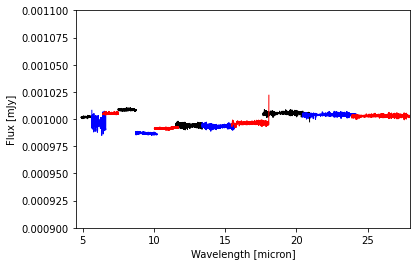

In [7]:
for j in range(0,6):
    ip.main(band_chan[j],[1,2],1,1e-7)
    
    result=AssignWcsStep.call('mock'+band_chan[j]+'-00.fits',save_results=True)
    result=AssignWcsStep.call('mock'+band_chan[j]+'-01.fits',save_results=True)
    
    wtype=3
    band=indiv1[j]
    filenames='mock'+band_chan[j]+'-00_assignwcsstep.fits','mock'+band_chan[j]+'-01_assignwcsstep.fits'
    modshep.setcube(filenames, band, wtype)
    
    band=indiv2[j]
    filenames='mock'+band_chan[j]+'-00_assignwcsstep.fits','mock'+band_chan[j]+'-01_assignwcsstep.fits'
    modshep.setcube(filenames, band, wtype)
        
    image1,header1=fits.getdata('pystack/pycube'+indiv1[j]+'.fits',header=True)
    
    num_x1=header1["NAXIS2"]
    num_y1=header1["NAXIS1"]
    num_chan1=header1["NAXIS3"]
    start_wavelength1=header1["CRVAL3"]
    step_wavelength1=header1["CDELT3"]
    pix_size1=header1["CD2_2"]
    
    a1=[0.0]*num_chan1
    for i in range(0,num_chan1):
        for m in range(0,num_x1):
            for n in range(0,num_y1):
                a1[i]=image1[i,m,n]+a1[i]    

    d1=[0.0]*num_chan1
    d1[0]=start_wavelength1
    for i in range(1,num_chan1):
        d1[i]=d1[i-1]+step_wavelength1
        
    for i in range(0,num_chan1):
        a1[i]=(a1[i]*(pix_size1*3600)*(pix_size1*3600)*(10**6))/(4.25*10**10)
    
    image2,header2=fits.getdata('pystack/pycube'+indiv2[j]+'.fits',header=True)
    
    num_x2=header2["NAXIS2"]
    num_y2=header2["NAXIS1"]
    num_chan2=header2["NAXIS3"]
    start_wavelength2=header2["CRVAL3"]
    step_wavelength2=header2["CDELT3"]
    pix_size2=header2["CD2_2"]
    
    a2=[0.0]*num_chan2
    for i in range(0,num_chan2):
        for m in range(0,num_x2):
            for n in range(0,num_y2):
                a2[i]=image2[i,m,n]+a2[i]   
                
    d2=[0.0]*num_chan2
    d2[0]=start_wavelength2
    for i in range(1,num_chan2):
        d2[i]=d2[i-1]+step_wavelength2                
                
    for i in range(0,num_chan2):
        a2[i]=(a2[i]*(pix_size2*3600)*(pix_size2*3600)*(10**6))/(4.25*10**10)
        
        
    plt.plot(d1,a1,'-', color=plot_color[j], lw=1)
    plt.plot(d2,a2,'-', color=plot_color[j], lw=1)
    plt.xlim(4.5,28)
    plt.ylim(0.0009,0.0011) 
    plt.xlabel('Wavelength [micron]')
    plt.ylabel('Flux [mJy]')
    
plt.savefig('point_source_flux_conservation_modshep_all.pdf')

#### Use WCS corrected mock files to test cube build.
#### cube_testing.json file looks like the following:

#### {"asn_rule": "Asn_MIRIFU_Dither", 
#### "targname": "MYTarget", 
#### "asn_pool": "jw00024_001_01_pool", 
#### "program": "0001",
#### "asn_type":"dither",
#### "asn_id": "a3001",
#### "target": "1",
#### "products": [ {"name": "det_image", 
#### "members": [ {"exptype": "SCIENCE", "expname": "mock12A-00_assignwcsstep.fits"}, 
#### {"exptype": "SCIENCE", "expname": "mock12A-01_assignwcsstep.fits"} ] } ] }

#### result=CubeBuildStep.call('cube_testing.json',save_results=True) (this will run each channel/band individually)
#### result=CubeBuildStep.call('cube_testing.json',save_results=True, --output_type=multi) (this will make one cube as the final output)

In [8]:
#The output should be 12 files: det_image_ch1-short_s3d.fits, det_image_ch1-medium_s3d.fits, etc.
result=CubeBuildStep.call('cube_testing.json',save_results=True)

2022-01-29 03:30:50,538 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.


2022-01-29 03:30:51,124 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep running with args ('cube_testing.json',).


2022-01-29 03:30:51,127 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'band', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': False}


2022-01-29 03:30:51,128 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step


2022-01-29 03:30:51,128 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud


2022-01-29 03:30:51,129 - stpipe.CubeBuildStep - INFO - Coordinate system to use: skyalign


2022-01-29 03:30:51,129 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: emsm


2022-01-29 03:30:51,130 - stpipe.CubeBuildStep - INFO - Power weighting distance: 2.0


2022-01-29 03:31:05,500 - stpipe.CubeBuildStep - INFO - The desired cubes cover the MIRI Channels: ['1', '1', '1', '2', '2', '2', '3', '3', '3', '4', '4', '4']


2022-01-29 03:31:05,501 - stpipe.CubeBuildStep - INFO - The desired cubes cover the MIRI subchannels: ['short', 'medium', 'long', 'short', 'medium', 'long', 'short', 'medium', 'long', 'short', 'medium', 'long']


2022-01-29 03:31:05,502 - stpipe.CubeBuildStep - INFO - Reading cube parameter file /grp/crds/cache/references/jwst/jwst_miri_cubepar_0006.fits


2022-01-29 03:31:06,607 - stpipe.CubeBuildStep - INFO - Output Cubes are single channel, single sub-channel IFU Cubes


2022-01-29 03:31:06,608 - stpipe.CubeBuildStep - INFO - Number of IFU cubes produced by this run = 12


2022-01-29 03:31:06,614 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:31:06,616 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:31:06,616 - stpipe.CubeBuildStep - INFO - Axis 1    53  27.00  45.00002674   0.13000000  -3.44499987   3.44499987


2022-01-29 03:31:06,617 - stpipe.CubeBuildStep - INFO - Axis 2    47  24.00  -0.00008455   0.13000000  -3.05499989   3.05499989


2022-01-29 03:31:06,618 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:31:06,619 - stpipe.CubeBuildStep - INFO - Axis 3   850   1.00   4.89049987   0.00100000   4.88999987   5.73999991


2022-01-29 03:31:06,619 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 1, short


2022-01-29 03:31:06,620 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch1-short_s3d.fits


2022-01-29 03:31:07,008 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6036 with wavelength below 4.887999866565224


2022-01-29 03:31:07,009 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 11113 with wavelength above 5.741999906778801


2022-01-29 03:31:09,142 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6036 with wavelength below 4.887999866565224


2022-01-29 03:31:09,144 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 11113 with wavelength above 5.741999906778801


2022-01-29 03:31:10,964 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:31:10,965 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:31:12,576 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:31:12,578 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:31:12,579 - stpipe.CubeBuildStep - INFO - Axis 1    53  27.00  44.99999770   0.13000000  -3.44499987   3.44499987


2022-01-29 03:31:12,580 - stpipe.CubeBuildStep - INFO - Axis 2    47  24.00  -0.00015869   0.13000000  -3.05499989   3.05499989


2022-01-29 03:31:12,581 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:31:12,581 - stpipe.CubeBuildStep - INFO - Axis 3   980   1.00   5.64049987   0.00100000   5.63999987   6.61999991


2022-01-29 03:31:12,582 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 1, medium


2022-01-29 03:31:12,583 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch1-medium_s3d.fits


2022-01-29 03:31:12,964 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5889 with wavelength below 5.637999866565224


2022-01-29 03:31:12,965 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10743 with wavelength above 6.62199991295347


2022-01-29 03:31:15,237 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5889 with wavelength below 5.637999866565224


2022-01-29 03:31:15,238 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10743 with wavelength above 6.62199991295347


2022-01-29 03:31:17,276 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:31:17,277 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:31:19,488 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:31:19,489 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:31:19,491 - stpipe.CubeBuildStep - INFO - Axis 1    53  27.00  45.00005443   0.13000000  -3.44499987   3.44499987


2022-01-29 03:31:19,492 - stpipe.CubeBuildStep - INFO - Axis 2    47  24.00  -0.00010518   0.13000000  -3.05499989   3.05499989


2022-01-29 03:31:19,492 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:31:19,493 - stpipe.CubeBuildStep - INFO - Axis 3  1091   1.00   6.42050008   0.00100000   6.42000008   7.51100013


2022-01-29 03:31:19,493 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 1, long


2022-01-29 03:31:19,494 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch1-long_s3d.fits


2022-01-29 03:31:19,865 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-01-29 03:31:19,866 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-01-29 03:31:22,193 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-01-29 03:31:22,194 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-01-29 03:31:24,204 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:31:24,205 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:31:25,807 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:31:25,808 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:31:25,809 - stpipe.CubeBuildStep - INFO - Axis 1    41  21.00  45.00002674   0.17000000  -3.48500004   3.48500004


2022-01-29 03:31:25,810 - stpipe.CubeBuildStep - INFO - Axis 2    37  19.00  -0.00008455   0.17000000  -3.14500003   3.14500003


2022-01-29 03:31:25,810 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:31:25,811 - stpipe.CubeBuildStep - INFO - Axis 3   631   1.00   7.49099977   0.00200000   7.48999977   8.75199983


2022-01-29 03:31:25,812 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 2, short


2022-01-29 03:31:25,813 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch2-short_s3d.fits


2022-01-29 03:31:26,142 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 8598 with wavelength below 7.48599977127742


2022-01-29 03:31:26,142 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12760 with wavelength above 8.755999830900691


2022-01-29 03:31:27,607 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 8598 with wavelength below 7.48599977127742


2022-01-29 03:31:27,607 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12760 with wavelength above 8.755999830900691


2022-01-29 03:31:28,763 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:31:28,764 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:31:31,000 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:31:31,001 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:31:31,001 - stpipe.CubeBuildStep - INFO - Axis 1    41  21.00  44.99999770   0.17000000  -3.48500004   3.48500004


2022-01-29 03:31:31,002 - stpipe.CubeBuildStep - INFO - Axis 2    37  19.00  -0.00015869   0.17000000  -3.14500003   3.14500003


2022-01-29 03:31:31,003 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:31:31,003 - stpipe.CubeBuildStep - INFO - Axis 3   745   1.00   8.72100027   0.00200000   8.72000027  10.21000034


2022-01-29 03:31:31,004 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 2, medium


2022-01-29 03:31:31,004 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch2-medium_s3d.fits


2022-01-29 03:31:31,354 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7291 with wavelength below 8.716000267188065


2022-01-29 03:31:31,354 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 13639 with wavelength above 10.214000337640755


2022-01-29 03:31:33,102 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7291 with wavelength below 8.716000267188065


2022-01-29 03:31:33,103 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 13639 with wavelength above 10.214000337640755


2022-01-29 03:31:34,520 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:31:34,522 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:31:36,121 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:31:36,122 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:31:36,123 - stpipe.CubeBuildStep - INFO - Axis 1    41  21.00  45.00005443   0.17000000  -3.48500004   3.48500004


2022-01-29 03:31:36,123 - stpipe.CubeBuildStep - INFO - Axis 2    37  19.00  -0.00010518   0.17000000  -3.14500003   3.14500003


2022-01-29 03:31:36,124 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:31:36,125 - stpipe.CubeBuildStep - INFO - Axis 3   855   1.00  10.03099973   0.00200000  10.02999973  11.73999981


2022-01-29 03:31:36,126 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 2, long


2022-01-29 03:31:36,127 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch2-long_s3d.fits


2022-01-29 03:31:36,486 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7871 with wavelength below 10.025999733130448


2022-01-29 03:31:36,487 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 11714 with wavelength above 11.743999814032577


2022-01-29 03:31:38,532 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7871 with wavelength below 10.025999733130448


2022-01-29 03:31:38,533 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 11714 with wavelength above 11.743999814032577


2022-01-29 03:31:40,282 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:31:40,284 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:31:41,871 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:31:41,872 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:31:41,873 - stpipe.CubeBuildStep - INFO - Axis 1    53  27.00  45.00006788   0.20000000  -5.30000008   5.30000008


2022-01-29 03:31:41,874 - stpipe.CubeBuildStep - INFO - Axis 2    45  23.00  -0.00017228   0.20000000  -4.50000007   4.50000007


2022-01-29 03:31:41,877 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:31:41,878 - stpipe.CubeBuildStep - INFO - Axis 3   647   1.00  11.53149973   0.00300000  11.52999973  13.47099975


2022-01-29 03:31:41,879 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 3, short


2022-01-29 03:31:41,880 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch3-short_s3d.fits


2022-01-29 03:31:42,224 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7131 with wavelength below 11.524499732768163


2022-01-29 03:31:42,225 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12807 with wavelength above 13.47649975004606


2022-01-29 03:31:44,118 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7131 with wavelength below 11.524499732768163


2022-01-29 03:31:44,119 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12807 with wavelength above 13.47649975004606


2022-01-29 03:31:45,686 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:31:45,687 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:31:48,014 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:31:48,015 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:31:48,016 - stpipe.CubeBuildStep - INFO - Axis 1    53  27.00  45.00009160   0.20000000  -5.30000008   5.30000008


2022-01-29 03:31:48,016 - stpipe.CubeBuildStep - INFO - Axis 2    45  23.00  -0.00015780   0.20000000  -4.50000007   4.50000007


2022-01-29 03:31:48,017 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:31:48,017 - stpipe.CubeBuildStep - INFO - Axis 3   754   1.00  13.37149989   0.00300000  13.36999989  15.63199991


2022-01-29 03:31:48,018 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 3, medium


2022-01-29 03:31:48,018 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch3-medium_s3d.fits


2022-01-29 03:31:48,364 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6411 with wavelength below 13.364499885356054


2022-01-29 03:31:48,365 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12155 with wavelength above 15.637499905424193


2022-01-29 03:31:50,564 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6411 with wavelength below 13.364499885356054


2022-01-29 03:31:50,565 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12155 with wavelength above 15.637499905424193


2022-01-29 03:31:52,481 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:31:52,483 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:31:54,081 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:31:54,082 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:31:54,083 - stpipe.CubeBuildStep - INFO - Axis 1    53  27.00  45.00008855   0.20000000  -5.30000008   5.30000008


2022-01-29 03:31:54,083 - stpipe.CubeBuildStep - INFO - Axis 2    45  23.00  -0.00012847   0.20000000  -4.50000007   4.50000007


2022-01-29 03:31:54,084 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:31:54,085 - stpipe.CubeBuildStep - INFO - Axis 3   870   1.00  15.44149958   0.00300000  15.43999958  18.04999960


2022-01-29 03:31:54,085 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 3, long


2022-01-29 03:31:54,086 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch3-long_s3d.fits


2022-01-29 03:31:54,419 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6560 with wavelength below 15.434499580180272


2022-01-29 03:31:54,420 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12301 with wavelength above 18.055499603273347


2022-01-29 03:31:57,091 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6560 with wavelength below 15.434499580180272


2022-01-29 03:31:57,092 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12301 with wavelength above 18.055499603273347


2022-01-29 03:31:59,492 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:31:59,493 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:32:01,786 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:32:01,787 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:32:01,787 - stpipe.CubeBuildStep - INFO - Axis 1    33  17.00  45.00006788   0.34999999  -5.77499990   5.77499990


2022-01-29 03:32:01,788 - stpipe.CubeBuildStep - INFO - Axis 2    27  14.00  -0.00017228   0.34999999  -4.72499992   4.72499992


2022-01-29 03:32:01,789 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:32:01,789 - stpipe.CubeBuildStep - INFO - Axis 3   544   1.00  17.66299985   0.00600000  17.65999985  20.92399988


2022-01-29 03:32:01,790 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 4, short


2022-01-29 03:32:01,790 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch4-short_s3d.fits


2022-01-29 03:32:02,079 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5058 with wavelength below 17.648999847006053


2022-01-29 03:32:02,080 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6125 with wavelength above 20.934999876189977


2022-01-29 03:32:03,410 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5058 with wavelength below 17.648999847006053


2022-01-29 03:32:03,411 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6125 with wavelength above 20.934999876189977


2022-01-29 03:32:04,465 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:32:04,466 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:32:06,062 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:32:06,063 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:32:06,064 - stpipe.CubeBuildStep - INFO - Axis 1    31  16.00  45.00009160   0.34999999  -5.42499991   5.42499991


2022-01-29 03:32:06,065 - stpipe.CubeBuildStep - INFO - Axis 2    27  14.00  -0.00015780   0.34999999  -4.72499992   4.72499992


2022-01-29 03:32:06,066 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:32:06,067 - stpipe.CubeBuildStep - INFO - Axis 3   631   1.00  20.42300008   0.00600000  20.42000008  24.20600011


2022-01-29 03:32:06,068 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 4, medium


2022-01-29 03:32:06,068 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch4-medium_s3d.fits


2022-01-29 03:32:06,361 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 3952 with wavelength below 20.40900007588789


2022-01-29 03:32:06,362 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6066 with wavelength above 24.217000109609216


2022-01-29 03:32:07,952 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 3952 with wavelength below 20.40900007588789


2022-01-29 03:32:07,953 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6066 with wavelength above 24.217000109609216


2022-01-29 03:32:09,270 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:32:09,271 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:32:10,852 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-01-29 03:32:10,853 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-01-29 03:32:10,854 - stpipe.CubeBuildStep - INFO - Axis 1    31  16.00  45.00008855   0.34999999  -5.42499991   5.42499991


2022-01-29 03:32:10,855 - stpipe.CubeBuildStep - INFO - Axis 2    27  14.00  -0.00012847   0.34999999  -4.72499992   4.72499992


2022-01-29 03:32:10,855 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-01-29 03:32:10,856 - stpipe.CubeBuildStep - INFO - Axis 3   737   1.00  23.89299939   0.00600000  23.88999939  28.31199943


2022-01-29 03:32:10,856 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 4, long


2022-01-29 03:32:10,857 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch4-long_s3d.fits


2022-01-29 03:32:11,166 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 4505 with wavelength below 23.87899938924238


2022-01-29 03:32:11,167 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6473 with wavelength above 28.32299942849204


2022-01-29 03:32:13,092 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 4505 with wavelength below 23.87899938924238


2022-01-29 03:32:13,093 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6473 with wavelength above 28.32299942849204


2022-01-29 03:32:14,738 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-01-29 03:32:14,739 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-01-29 03:32:17,093 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999087855 -0.000915108 44.999087855 0.000746004 45.000965632 0.000746004 45.000965632 -0.000915108


2022-01-29 03:32:17,096 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999058810 -0.000989250 44.999058810 0.000671862 45.000936588 0.000671862 45.000936588 -0.000989250


2022-01-29 03:32:17,099 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999115540 -0.000935738 44.999115540 0.000725374 45.000993318 0.000725374 45.000993318 -0.000935738


2022-01-29 03:32:17,103 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999082299 -0.000934552 44.999082299 0.000765448 45.000971188 0.000765448 45.000971188 -0.000934552


2022-01-29 03:32:17,106 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999053255 -0.001008694 44.999053255 0.000691306 45.000942143 0.000691306 45.000942143 -0.001008694


2022-01-29 03:32:17,109 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999109985 -0.000955182 44.999109985 0.000744818 45.000998873 0.000744818 45.000998873 -0.000955182


2022-01-29 03:32:17,112 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998623437 -0.001394503 44.998623437 0.001049942 45.001512326 0.001049942 45.001512326 -0.001394503


2022-01-29 03:32:17,115 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998647159 -0.001380027 44.998647159 0.001064418 45.001536047 0.001064418 45.001536047 -0.001380027


2022-01-29 03:32:17,118 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998644103 -0.001350696 44.998644103 0.001093749 45.001532991 0.001093749 45.001532991 -0.001350696


2022-01-29 03:32:17,121 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998512326 -0.001436169 44.998512326 0.001091608 45.001623437 0.001091608 45.001623437 -0.001436169


2022-01-29 03:32:17,125 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998633270 -0.001421693 44.998633270 0.001106084 45.001549936 0.001106084 45.001549936 -0.001421693


2022-01-29 03:32:17,128 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998630214 -0.001392362 44.998630214 0.001135415 45.001546880 0.001135415 45.001546880 -0.001392362


2022-01-29 03:32:17,587 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch1-short_s3d.fits


2022-01-29 03:32:18,003 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch1-medium_s3d.fits


2022-01-29 03:32:18,419 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch1-long_s3d.fits


2022-01-29 03:32:18,802 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch2-short_s3d.fits


2022-01-29 03:32:19,194 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch2-medium_s3d.fits


2022-01-29 03:32:19,586 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch2-long_s3d.fits


2022-01-29 03:32:19,984 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch3-short_s3d.fits


2022-01-29 03:32:20,388 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch3-medium_s3d.fits


2022-01-29 03:32:20,791 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch3-long_s3d.fits


2022-01-29 03:32:21,167 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch4-short_s3d.fits


2022-01-29 03:32:21,543 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch4-medium_s3d.fits


2022-01-29 03:32:21,921 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch4-long_s3d.fits


2022-01-29 03:32:21,923 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep done


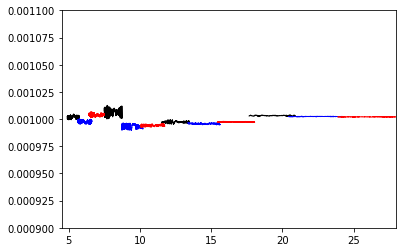

In [9]:
#Define band and channels
band_chan=['ch1-short','ch2-short','ch3-short','ch4-short']

for j in range(0,4):
    image3,header3=fits.getdata('det_image_'+band_chan[j]+'_s3d.fits',header=True)

    num_x3=header3["NAXIS2"]
    num_y3=header3["NAXIS1"]
    num_chan3=header3["NAXIS3"]
    start_wavelength3=header3["CRVAL3"]
    step_wavelength3=header3["CDELT3"]
    pix_size3=header3["CDELT1"]

    a3=[0.0]*num_chan3
    for i in range(0,num_chan3):
        for m in range(0,num_x3):
            for n in range(0,num_y3):
                a3[i]=image3[i,m,n]+a3[i]
            
    d3=[0.0]*num_chan3
    d3[0]=start_wavelength3
    for i in range(1,num_chan3):
        d3[i]=d3[i-1]+step_wavelength3
    
    for i in range(0,num_chan3):
        a3[i]=(a3[i]*(pix_size3*3600)*(pix_size3*3600)*(10**6))/(4.25*10**10)

    plt.plot(d3,a3,'-', color='black', lw=1)
    plt.xlim(4.5,28)
    plt.ylim(0.0009,0.0011) 

#Define band and channels
band_chan=['ch1-medium','ch2-medium','ch3-medium','ch4-medium']

for j in range(0,4):
    image3,header3=fits.getdata('det_image_'+band_chan[j]+'_s3d.fits',header=True)

    num_x3=header3["NAXIS2"]
    num_y3=header3["NAXIS1"]
    num_chan3=header3["NAXIS3"]
    start_wavelength3=header3["CRVAL3"]
    step_wavelength3=header3["CDELT3"]
    pix_size3=header3["CDELT1"]

    a3=[0.0]*num_chan3
    for i in range(0,num_chan3):
        for m in range(0,num_x3):
            for n in range(0,num_y3):
                a3[i]=image3[i,m,n]+a3[i]
            
    d3=[0.0]*num_chan3
    d3[0]=start_wavelength3
    for i in range(1,num_chan3):
        d3[i]=d3[i-1]+step_wavelength3
    
    for i in range(0,num_chan3):
        a3[i]=(a3[i]*(pix_size3*3600)*(pix_size3*3600)*(10**6))/(4.25*10**10)

    plt.plot(d3,a3,'-', color='blue', lw=1)
    plt.xlim(4.5,28)
    plt.ylim(0.0009,0.0011) 
    
#Define band and channels
band_chan=['ch1-long','ch2-long','ch3-long','ch4-long']

for j in range(0,4):
    image3,header3=fits.getdata('det_image_'+band_chan[j]+'_s3d.fits',header=True)

    num_x3=header3["NAXIS2"]
    num_y3=header3["NAXIS1"]
    num_chan3=header3["NAXIS3"]
    start_wavelength3=header3["CRVAL3"]
    step_wavelength3=header3["CDELT3"]
    pix_size3=header3["CDELT1"]

    a3=[0.0]*num_chan3
    for i in range(0,num_chan3):
        for m in range(0,num_x3):
            for n in range(0,num_y3):
                a3[i]=image3[i,m,n]+a3[i]
            
    d3=[0.0]*num_chan3
    d3[0]=start_wavelength3
    for i in range(1,num_chan3):
        d3[i]=d3[i-1]+step_wavelength3
    
    for i in range(0,num_chan3):
        a3[i]=(a3[i]*(pix_size3*3600)*(pix_size3*3600)*(10**6))/(4.25*10**10)

    plt.plot(d3,a3,'-', color='red', lw=1)
    plt.xlim(4.5,28)
    plt.ylim(0.0009,0.0011)     

#### Check the output of flat point source using Extract 1D

In [10]:
#Do Band A things
band_chan=['ch1-short','ch2-short','ch3-short','ch4-short']
for i in range(0,4):
    temppath1='det_image_'+band_chan[i]+'_s3d.fits'
    print(temppath1)
    result=Extract1dStep.call(temppath1) 
    result.save(band_chan[i]+"_output_file_from_extract1d.fits")
    
#Do Band B things
band_chan=['ch1-medium','ch2-medium','ch3-medium','ch4-medium']
for i in range(0,4):
    temppath1='det_image_'+band_chan[i]+'_s3d.fits'
    result=Extract1dStep.call(temppath1) 
    result.save(band_chan[i]+"_output_file_from_extract1d.fits")
    
#Do Band C things
band_chan=['ch1-long','ch2-long','ch3-long','ch4-long']
for i in range(0,4):
    temppath1='det_image_'+band_chan[i]+'_s3d.fits'
    result=Extract1dStep.call(temppath1) 
    result.save(band_chan[i]+"_output_file_from_extract1d.fits")

2022-01-29 03:32:55,184 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


det_image_ch1-short_s3d.fits


2022-01-29 03:32:56,005 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch1-short_s3d.fits',).


2022-01-29 03:32:56,008 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:32:56,195 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:32:56,217 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:32:57,290 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:32:57,292 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:32:57,293 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:32:57,310 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:33:06,116 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2022-01-29 03:33:06,363 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


det_image_ch2-short_s3d.fits


2022-01-29 03:33:07,453 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch2-short_s3d.fits',).


2022-01-29 03:33:07,456 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:33:07,629 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:33:07,640 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:33:08,878 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:33:08,879 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:33:08,880 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:33:08,893 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:33:14,227 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2022-01-29 03:33:14,469 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


det_image_ch3-short_s3d.fits


2022-01-29 03:33:14,578 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch3-short_s3d.fits',).


2022-01-29 03:33:14,580 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:33:14,754 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:33:14,766 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:33:16,021 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:33:16,022 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:33:16,023 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:33:16,036 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:33:22,534 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2022-01-29 03:33:22,767 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2022-01-29 03:33:22,871 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch4-short_s3d.fits',).


det_image_ch4-short_s3d.fits


2022-01-29 03:33:22,874 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:33:23,043 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:33:23,056 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:33:24,303 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:33:24,304 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:33:24,305 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:33:24,317 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:33:28,277 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2022-01-29 03:33:28,523 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2022-01-29 03:33:28,628 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch1-medium_s3d.fits',).


2022-01-29 03:33:28,630 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:33:28,811 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:33:28,823 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:33:30,070 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:33:30,071 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:33:30,071 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:33:30,084 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:33:40,063 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2022-01-29 03:33:40,300 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2022-01-29 03:33:40,418 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch2-medium_s3d.fits',).


2022-01-29 03:33:40,420 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:33:40,589 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:33:40,604 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:33:41,851 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:33:41,852 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:33:41,853 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:33:41,865 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:33:48,157 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2022-01-29 03:33:48,396 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2022-01-29 03:33:48,499 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch3-medium_s3d.fits',).


2022-01-29 03:33:48,502 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:33:48,682 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:33:48,695 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:33:49,957 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:33:49,958 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:33:49,960 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:33:49,973 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:33:57,533 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2022-01-29 03:33:57,764 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2022-01-29 03:33:57,867 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch4-medium_s3d.fits',).


2022-01-29 03:33:57,869 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:33:58,046 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:33:58,062 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:33:59,315 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:33:59,316 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:33:59,317 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:33:59,329 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:34:03,870 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2022-01-29 03:34:04,118 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2022-01-29 03:34:04,228 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch1-long_s3d.fits',).


2022-01-29 03:34:04,230 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:34:04,410 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:34:04,422 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:34:05,672 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:34:05,673 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:34:05,673 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:34:05,686 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:34:16,788 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2022-01-29 03:34:17,023 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2022-01-29 03:34:17,126 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch2-long_s3d.fits',).


2022-01-29 03:34:17,127 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:34:17,300 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:34:17,312 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:34:18,549 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:34:18,551 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:34:18,551 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:34:18,564 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:34:25,779 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2022-01-29 03:34:26,019 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2022-01-29 03:34:26,130 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch3-long_s3d.fits',).


2022-01-29 03:34:26,132 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:34:26,309 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:34:26,320 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:34:27,561 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:34:27,562 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:34:27,563 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:34:27,575 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:34:36,333 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2022-01-29 03:34:36,564 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2022-01-29 03:34:36,667 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch4-long_s3d.fits',).


2022-01-29 03:34:36,670 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2022-01-29 03:34:36,837 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-01-29 03:34:36,849 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-01-29 03:34:38,097 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-01-29 03:34:38,098 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2022-01-29 03:34:38,099 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2022-01-29 03:34:38,111 - stpipe.Extract1dStep - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-01-29 03:34:43,402 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


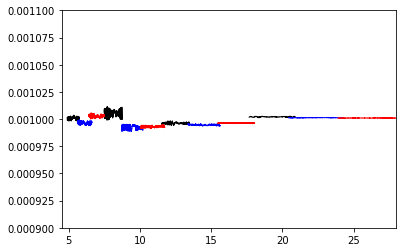

In [11]:
#Plot Band A
band_chan=['ch1-short','ch2-short','ch3-short','ch4-short']
for i in range(0,4):
    read_output1=fits.open(band_chan[i]+"_output_file_from_extract1d.fits")
    data1=Table.read(read_output1, hdu=1)
    flux1=data1['FLUX']
    wavelength1=data1['WAVELENGTH']
    plt.plot(wavelength1,flux1,'-', color='black', lw=1)

#Plot Band B
band_chan=['ch1-medium','ch2-medium','ch3-medium','ch4-medium']
for i in range(0,4):
    read_output1=fits.open(band_chan[i]+"_output_file_from_extract1d.fits")
    data1=Table.read(read_output1, hdu=1)
    flux1=data1['FLUX']
    wavelength1=data1['WAVELENGTH']
    plt.plot(wavelength1,flux1,'-', color='blue', lw=1)
    
#Plot Band C
band_chan=['ch1-long','ch2-long','ch3-long','ch4-long']
for i in range(0,4):
    read_output1=fits.open(band_chan[i]+"_output_file_from_extract1d.fits")
    data1=Table.read(read_output1, hdu=1)
    flux1=data1['FLUX']
    wavelength1=data1['WAVELENGTH']
    plt.plot(wavelength1,flux1,'-', color='red', lw=1)
    plt.xlim(4.5,28)
    plt.ylim(0.0009,0.0011) 

A successful test shows that the source is flat within 2%.